In [1]:
from __future__ import annotations

from ast import literal_eval
import sys; sys.path.append("../utils")
import _confusion_matrix

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import enchant

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [3]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw_pos{}.csv"
RAW_DATA_MAXLEN = [
    # 'none', 
    '300', 
    # '200'
]

In [4]:
class MisspellingVectorizer(TfidfVectorizer):
    """A custom vectorizer that only considers misspelled words."""

    def get_misspellings(self, X):
        d = enchant.Dict("en_UK")
        new_X = [[word for word in x.split() if (not d.check(word)) and (word.isalpha())]
                 for x in X]
        print(new_X, end="\n\n")
        new_X = [' '.join(doc) for doc in new_X]
        return new_X

    def transform(self, X, y=None):
        X = self.get_misspellings(X)
        return super(MisspellingVectorizer, self).transform(X)

    def fit(self, X, y=None):
        X = self.get_misspellings(X)
        return super(MisspellingVectorizer, self).fit(X, y)

In [5]:
models_df = pd.DataFrame({
    'model': [
        'LSVM', 
        'LogReg'
    ],
    'base': [
        SGDClassifier(loss='hinge'),
        SGDClassifier(loss='log_loss'), # 'log' is deprecated in 1.1
    ],
    'char_params': [
        {
            'cxf__chars__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), 
                                        (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
        },
        {
            'cxf__chars__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), 
                                        (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
        },
    ],
    'misspell_params': [
        {
            'cxf__misspell__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5),
                                           (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
        },
        {
            'cxf__misspell__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5),
                                           (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
        },
    ],
})

In [6]:
all_results = pd.DataFrame()

(8644, 1) (1268, 1) (8644,) (1268,)

======================================LSVM======================================
-------------------------------With maxlen='300'--------------------------------
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters:
{'cxf__chars__ngram_range': (1, 8), 'cxf__misspell__ngram_range': (1, 10)}

[['εστια'], ['Lol', 'dont', 'uti', 'greek'], ['Gok', 'Goks', 'Moar', 'Moar', 'qou', 'GC'], [], [], [], ['greeks', 'beuractic', 'courrpt'], ['Jannisary', 'brining', 'Mehmed', 'Alis', 'Ottomana', 'suprass'], ['Lol', 'Kolkotronis', 'Dervenakia', 'Muhammed'], [], [], ['astroturfing', 'Reddit', 'Islamists', 'behavior'], [], ['Eurocrats'], ['violetions'], [], [], [], ['turkish', 'representetives'], ['bn'], ['Nisyros', 'Sarakiniko', 'Simos', 'Elafonissos', 'Paxoi', 'Antipaxoi', 'Samothraki', 'Ikaria'], ['Merenda', 'Nutella'], ['Fountounia', 'Dracoulinia'], ['Karadayi'], ['Devuelveme', 'Chica'], ['ok', 'Električni', 'Orgazam', 'Igra', 'ro

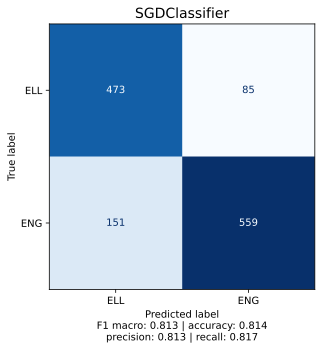

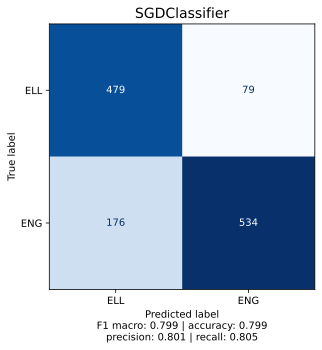

In [7]:
for maxlen in RAW_DATA_MAXLEN:
    df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''),
                                           encoding='utf-8')

    df, labels = encode_labels(df, 'label')

    X = df[['text']]
    y = df['label']

    gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=df['user_id']))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, end="\n\n")


    # run cross-validation, each time using only one of the three features
    char_vect = TfidfVectorizer(analyzer='char', ngram_range=(1, 1), binary=True)
    mspl_vect = MisspellingVectorizer(analyzer='char', ngram_range=(1, 1), binary=True)

    for i, row in models_df.iterrows():
        model = row['model']
        base = row['base']
        char_params = row['char_params']
        misspell_params = row['misspell_params']
        char_ngram_range = char_params['cxf__chars__ngram_range']
        misspell_ngram_range = misspell_params['cxf__misspell__ngram_range']

        cxf = ColumnTransformer([
            ('chars', char_vect, 'text'),
            ('misspell', mspl_vect, 'text'),
        ], remainder='drop')

        pipe = Pipeline([
            ('cxf', cxf),
            ('clf', base),
        ])

        print(f"{model:=^80}")
        print(f"With {maxlen=}".center(80, "-"))
        gs_grid = GridSearchCV(pipe, {**char_params, **misspell_params},
                               cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
        gs_grid.fit(X_train, y_train)
        print("Best hyperparameters:", gs_grid.best_params_, sep="\n", end="\n\n")
        y_pred = gs_grid.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")
        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=False, comment=f'1-10_grams_misspell_{maxlen}')
        gs_results = pd.DataFrame(gs_grid.cv_results_)
        gs_results['model'] = model
        gs_results['maxlen'] = maxlen
        all_results = pd.concat([all_results, gs_results])

        print(f"{model} done", end="\n\n")

In [8]:
# sort values in params column
all_results['params'] = all_results['params'].apply(lambda x: str(x))
all_results = all_results.sort_values(by='params')
all_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cxf__chars__ngram_range,param_cxf__misspell__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model,maxlen
0,2.713187,0.218058,66.744575,1.512205,"(1, 1)","(1, 1)","{'cxf__chars__ngram_range': (1, 1), 'cxf__miss...",0.617408,0.618430,0.619807,...,0.583216,0.598297,0.620098,0.577887,0.460929,0.586870,0.045767,100,LSVM,300
0,2.660098,0.351699,66.489161,1.639746,"(1, 1)","(1, 1)","{'cxf__chars__ngram_range': (1, 1), 'cxf__miss...",0.641561,0.602801,0.645128,...,0.592593,0.560128,0.600514,0.595943,0.524937,0.592867,0.033451,100,LogReg,300
9,91.899832,8.958502,63.467489,8.466784,"(1, 1)","(1, 10)","{'cxf__chars__ngram_range': (1, 1), 'cxf__miss...",0.668545,0.640137,0.687811,...,0.615625,0.632021,0.624547,0.612586,0.550487,0.626062,0.035076,94,LogReg,300
9,126.188938,9.047464,72.196976,13.107367,"(1, 1)","(1, 10)","{'cxf__chars__ngram_range': (1, 1), 'cxf__miss...",0.655491,0.652398,0.685965,...,0.623006,0.632406,0.612007,0.618436,0.575349,0.624861,0.031268,94,LSVM,300
1,3.971458,0.879731,61.641058,6.211522,"(1, 1)","(1, 2)","{'cxf__chars__ngram_range': (1, 1), 'cxf__miss...",0.627277,0.623025,0.614547,...,0.600997,0.593668,0.574406,0.579353,0.530974,0.587304,0.028890,99,LSVM,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,139.751573,2.075189,16.839083,1.029393,"(1, 9)","(1, 7)","{'cxf__chars__ngram_range': (1, 9), 'cxf__miss...",0.789582,0.743311,0.823927,...,0.762296,0.820496,0.783530,0.759615,0.778921,0.778675,0.028594,31,LogReg,300
87,155.584292,2.871091,17.294028,0.809340,"(1, 9)","(1, 8)","{'cxf__chars__ngram_range': (1, 9), 'cxf__miss...",0.795358,0.738602,0.833714,...,0.766078,0.818053,0.769253,0.769049,0.777634,0.779804,0.031351,26,LogReg,300
87,158.189666,4.141641,16.519191,1.033328,"(1, 9)","(1, 8)","{'cxf__chars__ngram_range': (1, 9), 'cxf__miss...",0.782594,0.757199,0.825833,...,0.755669,0.810957,0.754103,0.766728,0.772796,0.774472,0.029165,17,LSVM,300
88,181.310500,5.228384,16.668735,1.215212,"(1, 9)","(1, 9)","{'cxf__chars__ngram_range': (1, 9), 'cxf__miss...",0.793036,0.738650,0.837540,...,0.766023,0.816846,0.782109,0.772661,0.778719,0.784208,0.031649,10,LogReg,300


In [9]:
all_results = all_results.reset_index(drop=True)
all_results.to_csv('all_results_lsvm_logreg_ngrams_1-10_grams_misspell.csv', index=False, encoding='utf-8')

In [19]:
import pandas as pd
from ast import literal_eval
from IPython.display import display as ipy_display


with pd.option_context('display.max_rows', None):
    all_res = all_results[['model', 'maxlen', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
    all_res['n_grams'] = all_res['params'].apply(lambda x: x['cxf__chars__ngram_range']).astype(str)
    all_res['n_grams'] = all_res['n_grams'].apply(lambda x: literal_eval(x)) # convert n_grams to tuple
    all_res = all_res.rename(columns={'mean_test_score': 'F1-score', 'std_test_score': 'std'})
    all_res = all_res.sort_values(by=['model', 'maxlen', 'n_grams'])
    all_res = all_res.groupby(['model', 'maxlen', 'n_grams']).agg({'F1-score': 'mean', 'std': 'mean'})
    all_res = all_res.sort_index(level=2, key=lambda x: x.map(lambda y: y[1])) # sort n_grams naturally
    all_res = all_res.unstack('model')  # move model to columns and group by model
    all_res = all_res.swaplevel(axis=1).sort_index(axis=1)  # swap F1-score and std columns with model

    ipy_display(all_res)

# all_res.to_latex('all_results_lsvm_logreg_1-9_grams.tex', encoding='utf-8')

C:\Users\dimboump\AppData\Local\Temp\ipykernel_72772\806143292.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
C:\Users\dimboump\AppData\Local\Temp\ipykernel_72772\806143292.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['n_grams'] = all_res['params'].apply(lambda x: x['cxf__chars__ngram_range']).astype(str)
C:\Users\dimboump\AppData\Local\Temp\ipykernel_72772\806143292.py:10: SettingWithCopyWarning: 
A value is trying t

model               LSVM              LogReg          
                F1-score       std  F1-score       std
maxlen n_grams                                        
300    (1, 1)   0.616375  0.034233  0.619421  0.032866
       (1, 2)   0.703859  0.029481  0.718735  0.027593
       (1, 3)   0.752319  0.031849  0.760684  0.029333
       (1, 4)   0.757973  0.028709  0.771603  0.030237
       (1, 5)   0.760012  0.026730  0.770877  0.030456
       (1, 6)   0.758083  0.028527  0.767422  0.032221
       (1, 7)   0.754764  0.029009  0.763612  0.032087
       (1, 8)   0.752186  0.029843  0.755995  0.032906
       (1, 9)   0.747710  0.030465  0.750354  0.032918
       (1, 10)  0.742806  0.029998  0.745233  0.031907

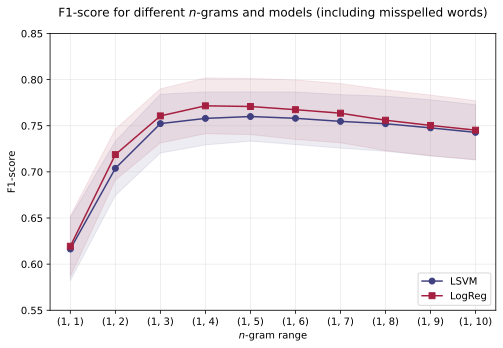

In [62]:
import re
from matplotlib.pyplot import Line2D

markers = ['o', 's', 'v', 'p', 'x', 'd', 'h', '8', 'P', '*']
colors = ['#404080', '#a52040', '#7d7dfa', '#d7d7d7', '#ff7f0e',
          '#2ca02c', '#1f77b4', '#9467bd', '#8c564b', '#e377c2']


fig, ax = plt.subplots(figsize=(8, 5))

for i, (model, group) in enumerate(all_res.groupby(level=0, axis=1)):
    group = group.droplevel(0, axis=1)  # drop F1-score and std
    group = group.sort_index(level=1, key=lambda x: x.map(lambda y: y[1]))  # sort n_grams naturally
    group = group.reset_index()
    group['n_grams'] = group['n_grams'].astype(str)
    group = group.set_index('n_grams')
    group.plot(y='F1-score', ax=ax, marker=markers[i], color=colors[i], label=model)
    # for x, y, yerr in zip(group.index, group['F1-score'], group['std']):
    #     ax.errorbar(x, y, yerr=yerr, fmt='none', color=colors[i], alpha=0.5, capsize=3, capthick=1, zorder=1)
    ax.fill_between(group.index, group['F1-score'] - group['std'], group['F1-score'] + group['std'],
                    color=colors[i], alpha=0.1, zorder=1)

ax.set_title('F1-score for different $n$-grams and models (including misspelled words)', pad=17)
ax.set_xlabel('$n$-gram range')
ax.set_ylabel('F1-score')
ax.set_ylim(0.55, 0.85)
ax.set_xticks(range(0, 10))
ax.set_xticklabels([f"(1, {i})" for i in range(1, 11)])
ax.grid(alpha=0.25, zorder=0)
ax.legend(loc='lower right')
plt.show();